In [1]:
import os.path

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
train_dataset = pd.read_csv('../../data/processed/trainData.csv')
test_dataset = pd.read_csv('../../data/processed/testData.csv')
synthetic_dataset = pd.read_csv('../../data/synthetic/SyntheticData.csv')

In [3]:
train_dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Probability
0,52,Private,187938,Some-college,10,Divorced,Sales,Not-in-family,White,Female,0,0,49,United-States,<=50K
1,43,Private,169628,Bachelors,13,Never-married,Sales,Unmarried,Black,Female,0,0,35,United-States,>50K
2,43,Self-emp-not-inc,89636,Bachelors,13,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,60,South,<=50K
3,32,Private,123291,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
4,32,Private,51150,12th,8,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36173,26,Private,177635,12th,8,Married-spouse-absent,Transport-moving,Unmarried,White,Male,0,0,40,Mexico,<=50K
36174,21,Private,293968,Some-college,10,Married-spouse-absent,Sales,Own-child,Black,Female,0,0,20,United-States,<=50K
36175,51,Local-gov,201040,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,Mexico,>50K
36176,53,Private,226135,9th,5,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,40,Jamaica,<=50K


In [4]:
test_dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Probability
0,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
1,34,Private,245487,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,45,Mexico,<=50K
2,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
3,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,>50K
4,54,Private,302146,HS-grad,9,Separated,Other-service,Unmarried,Black,Female,0,0,20,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9039,22,Private,269623,Some-college,10,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
9040,55,Private,224655,HS-grad,9,Separated,Priv-house-serv,Not-in-family,White,Female,0,0,32,United-States,<=50K
9041,61,Private,89686,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,48,United-States,<=50K
9042,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [5]:
synthetic_dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Probability
0,42,Private,285787,HS-grad,9,Never-married,Exec-managerial,Unmarried,Black,Male,0,0,40,United-States,<=50K
1,27,Private,103634,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,30,United-States,<=50K
2,22,Private,200593,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,30,United-States,<=50K
3,48,Self-emp-not-inc,246891,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,3,United-States,<=50K
4,36,Private,325374,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,40,Private,291300,Assoc-voc,11,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
999996,45,Local-gov,334039,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
999997,68,Self-emp-not-inc,195881,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,20,United-States,<=50K
999998,61,Federal-gov,161926,10th,6,Separated,Other-service,Not-in-family,Black,Female,0,0,37,United-States,>50K


In [6]:
def preprocess_data(dataset):
    print(dataset)
    dataset = dataset.drop(['workclass','fnlwgt','education','marital-status','occupation','relationship','native-country'],axis=1)
    print(dataset.head)
    dataset['sex'] = np.where(dataset['sex'] == ' Male', 1, 0)
    dataset['race'] = np.where(dataset['race'] != ' White', 0, 1)
    dataset['Probability'] = np.where(dataset['Probability'] == ' <=50K', 0, 1)
    dataset['age'] = np.where(dataset['age'] >= 70, 70, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 60 ) & (dataset['age'] < 70), 60, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 50 ) & (dataset['age'] < 60), 50, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 40 ) & (dataset['age'] < 50), 40, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 30 ) & (dataset['age'] < 40), 30, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 20 ) & (dataset['age'] < 30), 20, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 10 ) & (dataset['age'] < 10), 10, dataset['age'])
    dataset['age'] = np.where(dataset['age'] < 10, 0, dataset['age'])

    return dataset

In [7]:
train_dataset = preprocess_data(train_dataset)
print(train_dataset)
test_dataset = preprocess_data(test_dataset)
print(test_dataset)
synthetic_dataset = preprocess_data(synthetic_dataset)
print(synthetic_dataset)

       age          workclass  fnlwgt      education  education-num  \
0       52            Private  187938   Some-college             10   
1       43            Private  169628      Bachelors             13   
2       43   Self-emp-not-inc   89636      Bachelors             13   
3       32            Private  123291           12th              8   
4       32            Private   51150           12th              8   
...    ...                ...     ...            ...            ...   
36173   26            Private  177635           12th              8   
36174   21            Private  293968   Some-college             10   
36175   51          Local-gov  201040        Masters             14   
36176   53            Private  226135            9th              5   
36177   23            Private  315065           10th              6   

               marital-status          occupation    relationship  \
0                    Divorced               Sales   Not-in-family   
1        

In [8]:
test_dataset

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,Probability
0,40,13,1,1,5178,0,40,1
1,30,4,0,1,0,0,45,0
2,20,9,1,1,0,0,35,0
3,40,14,1,0,0,0,45,1
4,50,9,0,0,0,0,20,0
...,...,...,...,...,...,...,...,...
9039,20,10,1,1,0,0,40,0
9040,50,9,1,0,0,0,32,0
9041,60,9,1,1,0,0,48,0
9042,40,13,0,1,5455,0,40,0


In [9]:
train_dataset

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,Probability
0,50,10,1,0,0,0,49,0
1,40,13,0,0,0,0,35,1
2,40,13,0,0,0,0,60,0
3,30,8,1,1,0,0,40,0
4,30,8,1,0,0,0,40,0
...,...,...,...,...,...,...,...,...
36173,20,8,1,1,0,0,40,0
36174,20,10,0,0,0,0,20,0
36175,50,14,1,1,0,0,40,1
36176,50,5,0,1,0,0,40,0


In [10]:
from sklearn.preprocessing import MinMaxScaler

complete_dataset = pd.concat([train_dataset, synthetic_dataset])

scaler = MinMaxScaler()
scaler.fit(complete_dataset)
complete_dataset = pd.DataFrame(scaler.transform(complete_dataset), columns = train_dataset.columns)
test_dataset = pd.DataFrame(scaler.transform(test_dataset), columns = train_dataset.columns)

In [11]:
train_dataset

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,Probability
0,50,10,1,0,0,0,49,0
1,40,13,0,0,0,0,35,1
2,40,13,0,0,0,0,60,0
3,30,8,1,1,0,0,40,0
4,30,8,1,0,0,0,40,0
...,...,...,...,...,...,...,...,...
36173,20,8,1,1,0,0,40,0
36174,20,10,0,0,0,0,20,0
36175,50,14,1,1,0,0,40,1
36176,50,5,0,1,0,0,40,0


## using FairSmote to generate datapoints in order to minimize bias

In [12]:
protected_attributes = ('sex', 'race')

negative_female_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]))
negative_female_white = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]))
negative_male_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]))
negative_male_white = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]))
positive_female_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]))
positive_female_white = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]))
positive_male_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]))
positive_male_white = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]))

maximum = max(negative_female_nonWhite, negative_female_white, negative_male_nonWhite, negative_male_white, positive_female_nonWhite, positive_female_white, positive_male_nonWhite, positive_male_white)

minimum = min(negative_female_nonWhite, negative_female_white, negative_male_nonWhite, negative_male_white, positive_female_nonWhite, positive_female_white, positive_male_nonWhite, positive_male_white)

#to retrieve value from counts follow this format : counts[outcome => 1 is positive 0 is negative][sex => 0 is female and 1 is male][race => 0 is non-white and 1 is white]
counts = [[[negative_female_nonWhite, negative_female_white], [negative_male_nonWhite, negative_male_white]], [[positive_female_nonWhite, positive_female_white], [positive_male_nonWhite, positive_male_white]]]

countarr = [counts[0][0][0], counts[0][0][1], counts[0][1][0], counts[0][1][1], counts[1][0][0], counts[1][0][1], counts[1][1][0], counts[1][1][1]]

countlabels = ['N-F-NW', 'N-F-W', 'N-M-NW', 'N-M-W', 'P-F-NW', 'P-F-W', 'P-M-NW', 'P-M-W']

for i in range(8):
    if countarr[i] is minimum:
        print(f"{countlabels[i]} is the minimum with {countarr[i]} datapoints")

P-F-NW is the minimum with 6552 datapoints


In [13]:
df_negative_female_nonWhite = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]
df_negative_female_white = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]
df_negative_male_nonWhite = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]
df_negative_male_white = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]
df_positive_female_nonWhite = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]
df_positive_female_white = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]
df_positive_male_nonWhite = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]
df_positive_male_white = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]

dataframe_collection = [df_negative_female_nonWhite, df_negative_female_white, df_negative_male_nonWhite, df_negative_male_white, df_positive_female_nonWhite, df_positive_female_white, df_positive_male_nonWhite, df_positive_male_white]

# for dataframe in dataframe_collection:
#     dataframe['race'] = dataframe['race'].astype(str)
#     dataframe['sex'] = dataframe['sex'].astype(str)

new_dataframe_collection = []

for dataframe in dataframe_collection:
    new_dataframe_collection.append(dataframe.sample(n=minimum))

In [14]:
df = pd.concat(new_dataframe_collection)
df

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,Probability
383536,0.056604,0.533333,0.0,0.0,0.00000,0.0,0.397959,0.0
517708,0.245283,0.800000,0.0,0.0,0.00000,0.0,0.091837,0.0
919046,0.056604,0.600000,0.0,0.0,0.00000,0.0,0.397959,0.0
529725,1.000000,0.200000,0.0,0.0,0.00000,0.0,0.295918,0.0
451021,0.811321,0.533333,0.0,0.0,0.00000,0.0,0.040816,0.0
...,...,...,...,...,...,...,...,...
811608,0.433962,0.600000,1.0,1.0,0.00000,0.0,0.397959,1.0
279160,0.245283,0.800000,1.0,1.0,0.03103,0.0,0.602041,1.0
389821,0.622642,0.533333,1.0,1.0,0.00000,0.0,0.704082,1.0
580957,0.622642,0.866667,1.0,1.0,0.00000,0.0,0.602041,1.0


In [15]:
x_train, y_train = df.loc[:, df.columns != 'Probability'], df['Probability']
x_test, y_test = test_dataset.loc[:, test_dataset.columns != 'Probability'], test_dataset['Probability']

In [16]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [17]:
from sklearn.metrics import accuracy_score

print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7409332153914198


In [18]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
logistic_classifier.fit(x_train, y_train)

y_pred_logistic = logistic_classifier.predict(x_test)

print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_logistic)))


Accuracy score: 0.7469040247678018


In [19]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_svm)))

Accuracy score: 0.7815126050420168


In [20]:
from sklearn.metrics import confusion_matrix



print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test, y_pred_logistic))
print(confusion_matrix(y_test, y_pred_svm))

[[5144 1701]
 [ 642 1557]]
[[5189 1656]
 [ 633 1566]]
[[5593 1252]
 [ 724 1475]]


In [21]:
y_test

0       1.0
1       0.0
2       0.0
3       1.0
4       0.0
       ... 
9039    0.0
9040    0.0
9041    0.0
9042    0.0
9043    1.0
Name: Probability, Length: 9044, dtype: float64

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['<=50k', '>50k']))
print(classification_report(y_test, y_pred_logistic, target_names=['<=50k', '>50k']))

              precision    recall  f1-score   support

       <=50k       0.89      0.75      0.81      6845
        >50k       0.48      0.71      0.57      2199

    accuracy                           0.74      9044
   macro avg       0.68      0.73      0.69      9044
weighted avg       0.79      0.74      0.76      9044

              precision    recall  f1-score   support

       <=50k       0.89      0.76      0.82      6845
        >50k       0.49      0.71      0.58      2199

    accuracy                           0.75      9044
   macro avg       0.69      0.74      0.70      9044
weighted avg       0.79      0.75      0.76      9044



/home/rohamkoohestani/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/rohamkoohestani/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/rohamkoohestani/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plo

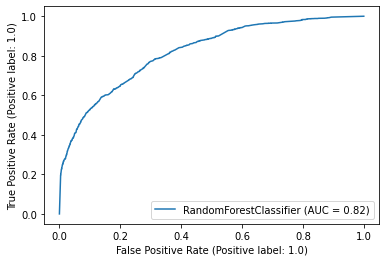

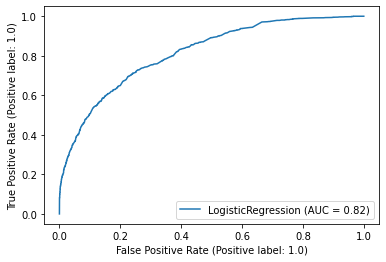

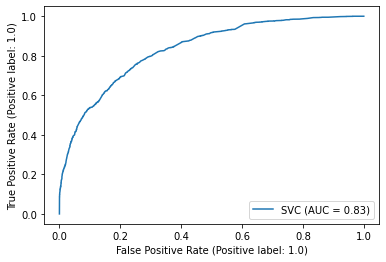

In [23]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(classifier, x_test, y_test)
plot_roc_curve(logistic_classifier, x_test, y_test)
plot_roc_curve(svm, x_test, y_test)

In [24]:
from Metrics import *

def get_allround_metrics(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes):

    print("recall :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'recall'))
    print("far :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'far'))
    print("precision :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'precision'))
    print("accuracy :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'accuracy'))
    print("F1 Score :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'F1'))
    print("aod :"+protected_attributes[0],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'aod'))
    print("eod :"+protected_attributes[0],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'eod'))

    print("SPD:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'SPD'))
    print("DI:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'DI'))

    print("-------------")

    print("recall :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'recall'))
    print("far :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'far'))
    print("precision :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'precision'))
    print("accuracy :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'accuracy'))
    print("F1 Score :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'F1'))
    print("aod :"+protected_attributes[1],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'aod'))
    print("eod :"+protected_attributes[1],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'eod'))

    print("SPD:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'SPD'))
    print("DI:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'DI'))

print("\n\n\nmetrics for random forest classifier:")
get_allround_metrics(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes)

print("\n\n\nmetrics for Logistic regression:")
get_allround_metrics(test_dataset, logistic_classifier, x_train, y_train, x_test, y_test, protected_attributes)

print("\n\n\nmetrics for SVM:")
get_allround_metrics(test_dataset, svm, x_train, y_train, x_test, y_test, protected_attributes)





metrics for random forest classifier:
recall : 0.71
far : 0.25
precision : 0.48
accuracy : 0.74
F1 Score : 0.57
aod :sex -0.0
eod :sex -0.03
SPD: 0.08
DI: 0.22
-------------
recall : 0.71
far : 0.25
precision : 0.48
accuracy : 0.74
F1 Score : 0.57
aod :race -0.02
eod :race -0.02
SPD: 0.06
DI: 0.17



metrics for Logistic regression:
recall : 0.71
far : 0.24
precision : 0.49
accuracy : 0.75
F1 Score : 0.58
aod :sex 0.01
eod :sex -0.0
SPD: 0.08
DI: 0.21
-------------
recall : 0.71
far : 0.24
precision : 0.49
accuracy : 0.75
F1 Score : 0.58
aod :race 0.01
eod :race 0.04
SPD: 0.07
DI: 0.2



metrics for SVM:
recall : 0.67
far : 0.18
precision : 0.54
accuracy : 0.78
F1 Score : 0.6
aod :sex -0.02
eod :sex -0.01
SPD: 0.12
DI: 0.36
-------------
recall : 0.67
far : 0.18
precision : 0.54
accuracy : 0.78
F1 Score : 0.6
aod :race -0.01
eod :race -0.03
SPD: 0.03
DI: 0.1
